基本ドメイン長: 3.601 um
総ドメイン数: 2777
JITコンパイル中...（初回のみ時間がかかります）
最適化を開始します...


Optimizing: 100%|██████████| 999/999 [22:14<00:00,  1.34s/it]


最適化完了 (1000ステップ, 1334.968 秒)

最終的なデバイス長: 10054.9 um
最終的なSHG変換効率: 74.4018%


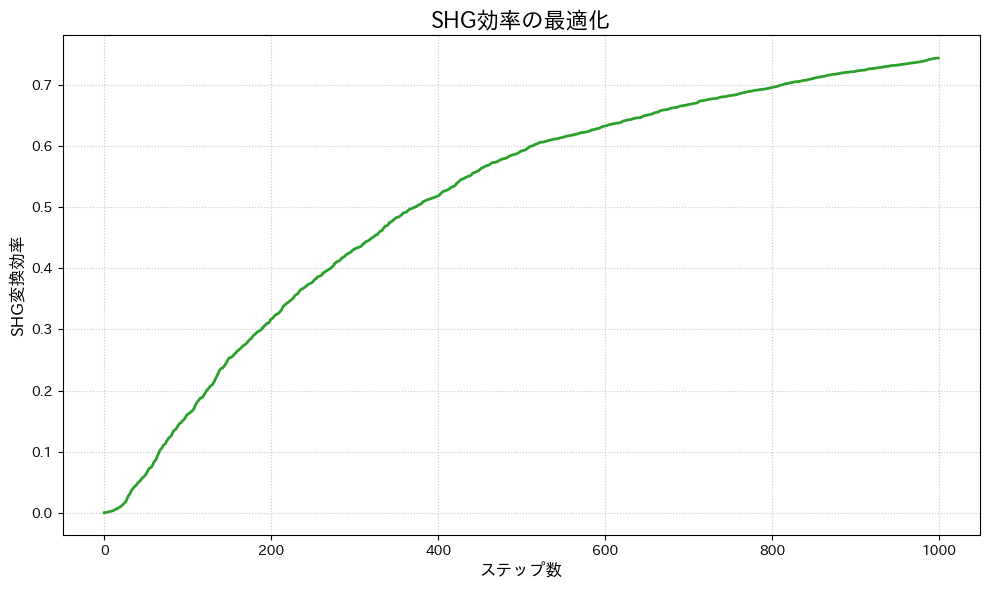

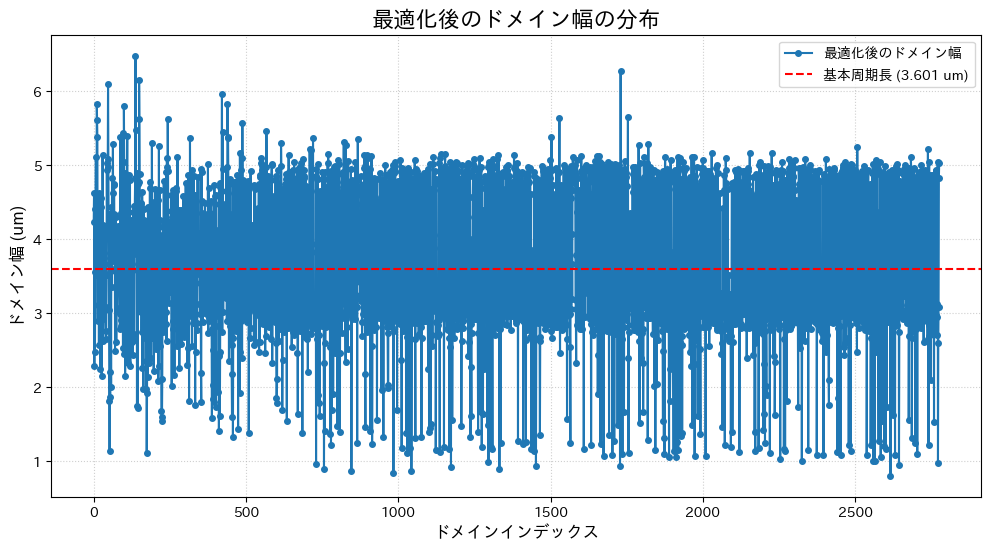

In [ ]:
import time
from collections.abc import Callable
from dataclasses import dataclass
from typing import NamedTuple

import japanize_matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from flax.training import train_state
from tqdm import tqdm

# ユーザー環境に qpm.mgoslt と qpm.cwes が存在することを前提とします
from qpm import cwes, mgoslt


# --- 1. 型定義 (Type Definitions) ---
@dataclass(frozen=True)
class ProblemConfig:
    """ユーザーが設定する、問題の基本パラメータ。"""

    design_temp_c: float = 70.0
    design_wavelength: float = 1.031
    target_length: float = 10000.0


class OptimizationPlan(NamedTuple):
    """最適化の実行に必要な関数とオブジェクトをまとめたもの。"""

    step_fn: Callable[[train_state.TrainState], tuple[train_state.TrainState, jax.Array]]
    optimizer: optax.GradientTransformation


class ProblemShape(NamedTuple):
    """問題の形状を定義するパラメータ。"""

    num_domains: int
    domain_len_shg: float


# --- 2. ファクトリー関数 (Factory Functions) ---
def create_objective_fn(config: ProblemConfig) -> Callable[[jax.Array], jax.Array]:
    """
    問題設定から、物理定数を計算し、目的関数を生成する。
    """
    # --- 物理定数の計算 ---
    delta_k_shg = mgoslt.calc_twm_delta_k(config.design_wavelength, config.design_wavelength, config.design_temp_c)
    delta_k_sfg = mgoslt.calc_twm_delta_k(config.design_wavelength, config.design_wavelength / 2.0, config.design_temp_c)
    domain_len_shg = jnp.pi / delta_k_shg
    num_domains = int(jnp.round(config.target_length / domain_len_shg))
    kappa_mag = jnp.arctanh(jnp.sqrt(0.95)) / 2000 * 2 / jnp.pi
    kappa_array = kappa_mag * jnp.power(-1.0, jnp.arange(num_domains))
    b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)

    # --- 目的関数の定義 ---
    @jax.jit
    def objective_fn(domain_widths: jax.Array) -> jax.Array:
        superlattice = jnp.stack([domain_widths, kappa_array], axis=1)
        b_final = cwes.simulate_twm(
            # NOTE: FW, SHG, THGの順で複素振幅が計算される
            superlattice,
            delta_k_shg,
            delta_k_sfg,
            b_initial,
        )
        shg_efficiency = jnp.abs(b_final[2]) ** 2
        return -shg_efficiency

    return objective_fn


def create_lbfgs_plan(objective_fn: Callable[[jax.Array], jax.Array]) -> OptimizationPlan:
    """
    与えられた目的関数に対して、L-BFGSのステップ関数とオプティマイザを生成する。
    """
    optimizer = optax.lbfgs()
    value_and_grad_fn = jax.value_and_grad(objective_fn)

    @jax.jit
    def step_fn(state: train_state.TrainState) -> tuple[train_state.TrainState, jax.Array]:
        loss, grads = value_and_grad_fn(state.params)
        updates, new_opt_state = optimizer.update(grads, state.opt_state, state.params, value=loss, grad=grads, value_fn=objective_fn)
        new_params = optax.apply_updates(state.params, updates)
        new_state = state.replace(step=state.step + 1, params=new_params, opt_state=new_opt_state)
        return new_state, loss

    return OptimizationPlan(step_fn=step_fn, optimizer=optimizer)


def get_problem_shape(config: ProblemConfig) -> ProblemShape:
    """問題の形状（ドメイン数と基本長）を計算して返す。"""
    delta_k_shg = mgoslt.calc_twm_delta_k(config.design_wavelength, config.design_wavelength, config.design_temp_c)
    domain_len_shg = jnp.pi / delta_k_shg
    num_domains = int(jnp.round(config.target_length / domain_len_shg))
    return ProblemShape(num_domains=num_domains, domain_len_shg=domain_len_shg)


def initialize_state(shape: ProblemShape, plan: OptimizationPlan, key: jax.random.PRNGKey) -> train_state.TrainState:
    """最適化の初期状態(TrainState)を生成する。"""
    initial_params = jax.random.uniform(key, shape=(shape.num_domains,), minval=0.5 * shape.domain_len_shg, maxval=1.5 * shape.domain_len_shg)
    return train_state.TrainState.create(apply_fn=None, params=initial_params, tx=plan.optimizer)


# --- 3. 実行と可視化 (Execution and Visualization) ---
def plot_results(history: dict, final_params: jax.Array, shape: ProblemShape):
    """最適化の結果をプロットする。"""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(jnp.array(history["shg_eff"]), color="tab:green", lw=2)
    ax.set_xlabel("ステップ数", fontsize=12)
    ax.set_ylabel("SHG変換効率", fontsize=12)
    ax.set_title("SHG効率の最適化", fontsize=16)
    ax.grid(True, linestyle=":", alpha=0.7)
    fig.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(final_params, "o-", markersize=4, label="最適化後のドメイン幅")
    plt.axhline(y=shape.domain_len_shg, color="r", linestyle="--", label=f"基本周期長 ({shape.domain_len_shg:.3f} um)")
    plt.xlabel("ドメインインデックス", fontsize=12)
    plt.ylabel("ドメイン幅 (um)", fontsize=12)
    plt.title("最適化後のドメイン幅の分布", fontsize=16)
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.show()


"""最適化プロセス全体を統括するメイン関数。"""
# --- 1. 初期設定 ---
config = ProblemConfig()
shape = get_problem_shape(config)
objective_fn = create_objective_fn(config)
plan = create_lbfgs_plan(objective_fn)

print(f"基本ドメイン長: {shape.domain_len_shg:.3f} um")
print(f"総ドメイン数: {shape.num_domains}")

# --- 2. 状態の初期化 ---
key = jax.random.PRNGKey(int(time.time()))
state = initialize_state(shape, plan, key)

# --- 3. 最適化ループの実行 ---
num_steps = 1000
history = {"shg_eff": []}

print("JITコンパイル中...（初回のみ時間がかかります）")
state, loss = plan.step_fn(state)  # ウォームアップ
history["shg_eff"].append(-loss)
print("最適化を開始します...")

start_time = time.perf_counter()
for _ in tqdm(range(num_steps - 1), desc="Optimizing"):
    state, loss = plan.step_fn(state)
    history["shg_eff"].append(-loss)

final_params = state.params
jax.block_until_ready(final_params)
end_time = time.perf_counter()
print(f"最適化完了 ({num_steps}ステップ, {end_time - start_time:.3f} 秒)")

# --- 4. 結果の集計と可視化 ---
final_shg_eff = history["shg_eff"][-1]
final_length = jnp.sum(final_params)

print(f"\n最終的なデバイス長: {final_length:.1f} um")
print(f"最終的なSHG変換効率: {final_shg_eff:.4%}")

plot_results(history, final_params, shape)